# QC + Doublet Finder

Basic QC. Find doublets per sample, visualize on overall UMAP and mark them.

In [1]:
library(Seurat)
library(dplyr)
library(ggplot2)
library(patchwork)
library(DoubletFinder)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [6]:
DAYS = c("D0", "D2", "D4", "D6", "D8", "D10", "D12", "D14")

In [7]:
day_config = read.table("../../figures_factory/configs/day.tsv", comment.char = '', header=T)
day_config$colour = as.character(day_config$colour)
day_config$day = factor(day_config$day, levels=DAYS)
rownames(day_config) = day_config$day
day_config

day colour 
D0  D0  #A61C24
D2  D2  #FF70A6
D4  D4  #D6E82F
D6  D6  #B14AED
D8  D8  #2D3142
D10 D10 #FC7753
D12 D12 #0AABB7
D14 D14 #336699

## Load Data

In [3]:
# aggregated cellranger data
rna.data = Read10X("/srv/scratch/surag/scRNA-reprog/filtered_feature_bc_matrix")

In [4]:
rna = CreateSeuratObject(counts = rna.data, project = "scRNA-reprog", min.cells = 3, min.features = 200)

In [313]:
rownames(rna)[grep("lnc", rownames(rna), ignore.case = T)]

[1] "LNCTAM34A" "ERLNC1"    "THORLNC"   "LNCSRLR"   "LNCPRESS2" "FILNC1"   
 [7] "LNCPRESS1" "FLNC"      "LNCOC1"    "LNCAROD"   "LNCOG"     "ARLNC1"

In [8]:
rna[["sample"]] = DAYS[as.numeric(lapply(strsplit(colnames(rna), "-"), "[[", 2))]

In [9]:
head(rna@meta.data)

orig.ident   nCount_RNA nFeature_RNA sample
AAACCCAAGAGTGACC-1 scRNA-reprog 12431      3300         D0    
AAACCCAAGTGCCAGA-1 scRNA-reprog 11132      3304         D0    
AAACCCACAACTCGAT-1 scRNA-reprog 20218      4449         D0    
AAACCCACACCATTCC-1 scRNA-reprog 13101      3788         D0    
AAACCCACACGACAGA-1 scRNA-reprog 29895      5438         D0    
AAACCCACACGCGTCA-1 scRNA-reprog  7944      2612         D0

In [304]:
ncol(rna)

[1] 73908

In [10]:
table(rna@meta.data$sample)


   D0   D10   D12   D14    D2    D4    D6    D8 
11648 13280  9405 10154  3708  7082 11069  7562 

## Process

### QC Filters

In [229]:
rna[["percent.mt"]] = PercentageFeatureSet(rna, pattern="^MT-")
rna[["percent.oskm"]] = PercentageFeatureSet(rna, pattern="^(POU5F1|KLF4|MYC|SOX2)$")

In [12]:
quantile(rna@meta.data$nFeature_RNA, c(0, 0.1, 0.25, 0.5, 0.9, .99, 1))

0%   10%   25%   50%   90%   99%  100% 
  199  1526  2551  3349  5270  7082 10195

In [13]:
quantile(rna@meta.data$nCount_RNA, c(0, 0.1, 0.25, 0.5, 0.9, .99, 1))

0%       10%       25%       50%       90%       99%      100% 
   228.00   3609.00   7487.00  11891.50  27498.30  50736.37 153436.00

In [14]:
quantile(rna@meta.data$percent.mt, c(0, 0.1, 0.25, 0.5, 0.9, .99, 1))

0%       10%       25%       50%       90%       99%      100% 
 0.000000  4.121384  5.179229  6.690476 12.777343 84.518322 95.614213

In [246]:
quantile(rna@meta.data$percent.oskm, c(0, 0.1, 0.25, 0.5, 0.9, .99, 1))

0%         10%         25%         50%         90%         99% 
 0.00000000  0.00000000  0.01466867  0.12497508  0.49307537  5.77890481 
       100% 
96.21305964

In [206]:
qc_plot <- function(df, xlab, ylab, xline, yline) {
    ggplot(df, aes(x=x,y=y)) +
    stat_binhex(aes(fill=log10(1+..count..)), bins=100) +
    scale_fill_viridis_c() +
    xlab(xlab) + ylab(ylab) +
    geom_vline(xintercept = xline, col='red') + 
    geom_hline(yintercept = yline, col='red') +
    theme_bw()
}

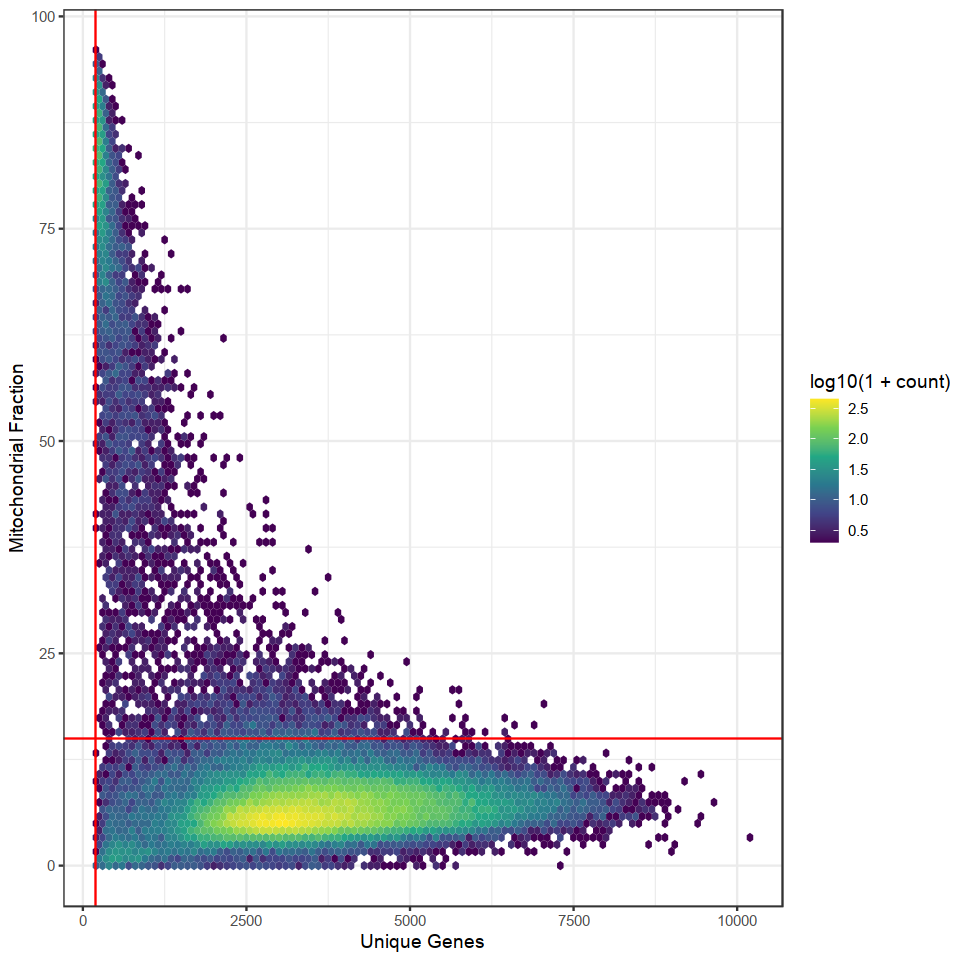

In [213]:
options(repr.plot.width = 8, repr.plot.height = 8)
qc_plot(data.frame(
    x=rna@meta.data$nFeature_RNA,
    y=rna@meta.data$percent.mt), 
        "Unique Genes", 
        "Mitochondrial Fraction",
       200, 15)

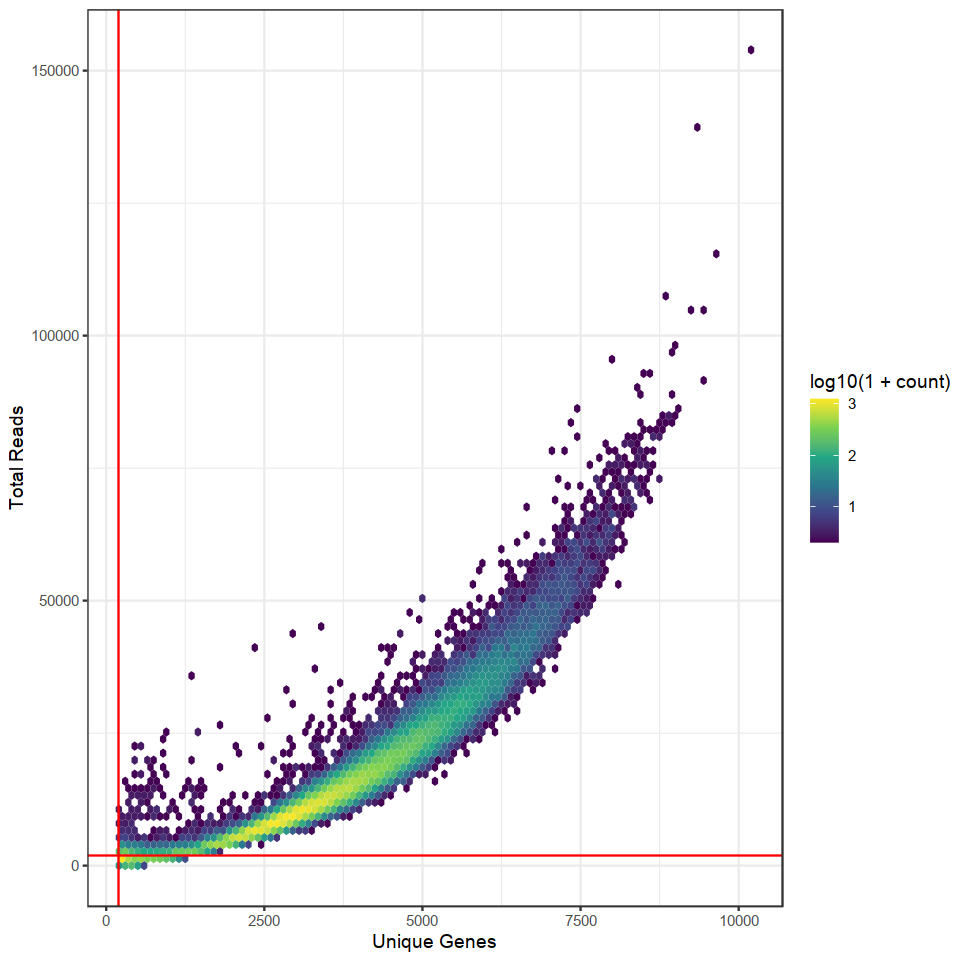

In [208]:
options(repr.plot.width = 8, repr.plot.height = 8)
qc_plot(data.frame(x=rna@meta.data$nFeature_RNA,
                   y=rna@meta.data$nCount_RNA),
        "Unique Genes", "Total Reads",
       200,2000)

In [17]:
head(rna@meta.data)

orig.ident   nCount_RNA nFeature_RNA sample percent.mt
AAACCCAAGAGTGACC-1 scRNA-reprog 12431      3300         D0     4.231357  
AAACCCAAGTGCCAGA-1 scRNA-reprog 11132      3304         D0     5.821056  
AAACCCACAACTCGAT-1 scRNA-reprog 20218      4449         D0     4.787813  
AAACCCACACCATTCC-1 scRNA-reprog 13101      3788         D0     4.121823  
AAACCCACACGACAGA-1 scRNA-reprog 29895      5438         D0     4.448904  
AAACCCACACGCGTCA-1 scRNA-reprog  7944      2612         D0     4.770896

In [258]:
md = rna@meta.data
conds = md$nFeature_RNA > 200 & md$percent.mt <15 & md$percent.oskm <10 & md$nCount_RNA > 2000 # & md$nFeature_RNA<5000
sum(conds)
table(md$sample[conds])

[1] 65784


   D0   D10   D12   D14    D2    D4    D6    D8 
11465 12283  8415  8861  2930  6154  9203  6473 

In [259]:
select_bool = rep(0, ncol(rna))
select_bool[conds] = 1
rna[['selected']]= select_bool

In [260]:
# rna_subset <- subset(rna, subset = nFeature_RNA > 200 & nFeature_RNA < 5000 & percent.mt < 10)
rna_subset = subset(rna, subset = selected==1)

In [261]:
table(rna_subset@meta.data$sample)


   D0   D10   D12   D14    D2    D4    D6    D8 
11465 12283  8415  8861  2930  6154  9203  6473 

## DoubletFinder

In [314]:
doublets = c()

# TODO: technically pK needs to be optimised per sample [need to code that in]
for (d in DAYS) {
    rna_sample = subset(rna_subset, subset = sample==d)
    
    rna_sample <- NormalizeData(rna_sample)
    rna_sample <- FindVariableFeatures(rna_sample, selection.method = "vst", nfeatures = 2000)
    all.genes <- rownames(rna_sample)
    rna_sample <- ScaleData(rna_sample, features = all.genes)
    rna_sample <- RunPCA(rna_sample, features = VariableFeatures(object = rna_sample))
    rna_sample <- RunUMAP(rna_sample, dims = 1:10)
    
    nExp_poi <- round(0.1*ncol(rna_sample)) # 10% stringent (?)
    rna_sample <- doubletFinder_v3(rna_sample, PCs = 1:10, pN = 0.25, pK = 0.01, nExp = nExp_poi, reuse.pANN = FALSE, sct = FALSE)
    
    doublets = c(doublets_pk3, rownames(rna_sample@meta.data)[rna_sample@meta.data[, grep("DF.classifications", colnames(rna_sample@meta.data))[1]]=="Doublet"])
}

[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Computing pANN..."
[1] "Classifying doublets.."


Centering and scaling data matrix

PC_ 1 
Positive:  POU5F1, UTF1, MT1X, PLAAT3, MT1G, LIM2, DPPA4, ESRG, ASRGL1, HMGA1 
	   NANOG, SPINT2, AK4, L1TD1, TUBB4A, TDGF1, PARP1, TOMM7, TTYH1, SEMA6A 
	   GSTP1, MIR302CHG, UPP1, SLIRP, NLRP7, UGP2, LNCPRESS1, TNNT1, HSPD1, NDUFAB1 
Negative:  COL1A2, B2M, LGALS1, COL1A1, COL6A3, COL3A1, TPM2, SPARC, FN1, CHN1 
	   COL6A1, TIMP1, EMILIN1, MALAT1, CTHRC1, MMP2, SH3BGRL3, COL6A2, HLA-B, CD99 
	   TGFBI, TIMP2, COL5A2, TSPO, S100A6, PDGFRB, COL12A1, FTL, MFAP4, PCOLCE 
PC_ 2 
Positive:  ANXA1, MAP1B, SFRP1, PCLAF, PMP22, AKR1C3, PCDH9, SNTG1, MYC, RGS2 
	   HOTAIRM1, CAVIN2, MOXD1, NFIA, ID3, SERTAD4, KRT18, PBK, CYTL1, PCLO 
	   S100A4, CNRIP1, CD70, THSD7A, PTTG1, GYPC, NRP2, PCDH7, DANCR, CENPF 
Negative:  IFITM3, MX1, SAT1, IFI27, IFI6, IFITM1, LY6E, BST2, CD82, MMP11 
	   RGCC, SPON2, APOE, ITGA1, NLRP7, COL5A1, TDGF1, EPSTI1, MT1H, MT1G 
	   UACA, TYMP, ISG15, CTHRC1, MT1E, COL6A2, STAT1, GJA1, FRAT2, SPINT2 
PC_ 3 
Positive:  GYPC, KLF4,

[1] "Creating 2805 artificial doublets..."
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Computing pANN..."
[1] "Classifying doublets.."


Centering and scaling data matrix

PC_ 1 
Positive:  POU5F1, UTF1, MT1X, MT1G, SPINT2, TDGF1, LIM2, UGP2, APOE, PLAAT3 
	   NLRP7, HSP90AA1, MT1H, SLIRP, ESRG, L1TD1, TUBB2B, SET, RPS17, EPCAM 
	   MT1F, TMEM160, TCEA1, TUBB4A, F11R, MYBL2, SEMA6A, ASRGL1, HSPE1, PRR13 
Negative:  COL1A2, COL6A3, COL1A1, B2M, COL3A1, FN1, TIMP1, COL6A1, HLA-B, EMILIN1 
	   BGN, COL6A2, TPM2, SPARC, TGFBI, MFAP4, IGFBP7, MMP2, LGALS1, S100A6 
	   COL5A2, COL4A1, IER3, COL4A2, COL12A1, TSPO, CHN1, RARRES2, CTHRC1, TIMP3 
PC_ 2 
Positive:  IFI6, APOE, MT1H, C11orf96, PDLIM1, TIMP3, NLRP7, MT1E, INHBA, RAMP1 
	   CD82, SPON2, CTHRC1, DPPA3, CEBPB, COL8A1, MT1G, IFI27, HOPX, ISLR 
	   MMP11, MT2A, LINC01356, IGFBP3, BST2, HES4, LUM, CYTOR, PHLDA2, FOXD3-AS1 
Negative:  PCDH9, GYPC, MAP1B, AP1S2, AKR1C3, CAVIN2, ANXA1, PCDH7, CD70, AKR1C1 
	   PCLAF, ROBO1, CCDC50, MYC, NFIA, SFRP1, FBN2, CALB1, AKR1C2, VIM 
	   MOXD1, IGFBP2, KCNE5, PON2, MEOX2, KRT8, LEMD1, SNTG1, CYTL1, SERTAD4-AS1 
PC_ 3 
Positive:  HLA-

[1] "Creating 2954 artificial doublets..."
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Computing pANN..."
[1] "Classifying doublets.."


In [315]:
length(unique(doublets))

[1] 6428

In [ ]:
# sweep.res.sample <- paramSweep_v3(rna_sample, PCs = 1:10, sct = FALSE)
# sweep.stats.sample <- summarizeSweep(sweep.res.sample, GT = FALSE)
# bcmvn.sample <- find.pK(sweep.stats.sample)

## Viz

## With doublets

In [265]:
rna_w_doub = rna_subset
    
rna_w_doub <- NormalizeData(rna_w_doub)
rna_w_doub <- FindVariableFeatures(rna_w_doub, selection.method = "vst", nfeatures = 2000)
all.genes <- rownames(rna_w_doub)
rna_w_doub <- ScaleData(rna_w_doub, features = all.genes)
rna_w_doub <- RunPCA(rna_w_doub, features = VariableFeatures(object = rna_sample))
rna_w_doub <- RunUMAP(rna_w_doub, dims = 1:10)

Centering and scaling data matrix

PC_ 1 
Positive:  LGALS1, TPM2, COL1A1, COL6A3, B2M, COL1A2, SH3BGRL3, COL6A2, FN1, TIMP1 
	   COL6A1, CTSB, CTHRC1, COL3A1, MYL9, SPARC, MMP2, S100A6, CD59, VIM 
	   PCOLCE, LGALS3, CAV1, TSPO, HLA-B, MALAT1, IER3, CD99, TGFBI, TAGLN 
Negative:  LIM2, UTF1, PLAAT3, MT1G, L1TD1, SPINT2, TUBB4A, ESRG, POU5F1, MT1X 
	   TDGF1, ASRGL1, SEMA6A, MT1H, F11R, CD24, MIR302CHG, TUBB2B, NLRP7, TTYH1 
	   FRAT2, CD70, SLIRP, EPCAM, LINC00678, LNCPRESS1, TRIML2, TNFSF9, MT1F, CXADR 
PC_ 2 
Positive:  APOE, NLRP7, TDGF1, NODAL, NLRP2, EPCAM, LINC01356, DPPA3, MT1F, FGF4 
	   DNMT3B, SAT1, FOXD3-AS1, AC064802.1, PDLIM1, DPPA2, LIN28A, ESRP1, APOC1, SLC66A3 
	   FOXH1, AC005062.1, ERVH48-1, PIM1, MT1H, RAB25, PLBD1, SPINT2, AC027288.1, CCND2 
Negative:  ANXA1, MYC, CD36, S100A16, GSN, ODC1, SOX2, CAVIN2, PCDH9, ARHGAP18 
	   KLF4, PCLAF, PI16, PCDH10, PLA2G7, S100A6, AZGP1, LINC00437, PTHLH, NRP2 
	   CALB1, ROBO1, ALDH1A2, THSD7A, MT-ND1, GYPC, LYPLAL1-DT, SNCG, MA

In [268]:
rna_w_doub

An object of class Seurat 
27632 features across 65784 samples within 1 assay 
Active assay: RNA (27632 features, 2000 variable features)
 2 dimensional reductions calculated: pca, umap

In [316]:
rna_w_doub[['doublet']] = rownames(rna_w_doub@meta.data) %in% doublets

In [317]:
plot_df <- data.frame(pc1=data.frame(Embeddings(rna_w_doub, reduction='umap'))$UMAP_1,
                 pc2=data.frame(Embeddings(rna_w_doub, reduction='umap'))$UMAP_2,
                 sample=rna_w_doub@meta.data$sample)
plot_df = plot_df[sample(dim(plot_df)[1]), ]

by_day <- ggplot(plot_df) +
geom_point(aes(x=pc1, y=pc2, color=factor(sample, levels=DAYS)), stroke=0, size=1) +
theme_classic() +
scale_color_manual(values=day_config$colour) +
xlab("UMAP 1") + ylab("UMAP 2") +
theme(plot.title = element_text(hjust = 0.5),
      text = element_text(size=12),
      axis.line=element_blank(),
      axis.text.x=element_blank(),
      axis.text.y=element_blank(),
      axis.ticks=element_blank(),
      panel.border = element_rect(colour = "black", fill=NA, size=0.5)) +
guides(colour = guide_legend(title="Day",
     override.aes = list(shape=16, alpha=1, size=4)))

In [318]:
plot_df <- data.frame(pc1=data.frame(Embeddings(rna_w_doub, reduction='umap'))$UMAP_1,
                 pc2=data.frame(Embeddings(rna_w_doub, reduction='umap'))$UMAP_2,
                 doub=rna_w_doub@meta.data$doublet)
plot_df = plot_df[sample(dim(plot_df)[1]), ]

by_doub <- ggplot(plot_df) +
geom_point(aes(x=pc1, y=pc2, color=doub), stroke=0, size=1) +
theme_classic() +
xlab("UMAP 1") + ylab("UMAP 2") +
theme(plot.title = element_text(hjust = 0.5),
      text = element_text(size=12),
      axis.line=element_blank(),
      axis.text.x=element_blank(),
      axis.text.y=element_blank(),
      axis.ticks=element_blank(),
      panel.border = element_rect(colour = "black", fill=NA, size=0.5)) +
guides(colour = guide_legend(title="Day",
     override.aes = list(shape=16, alpha=1, size=4)))

In [319]:
plot_df <- data.frame(pc1=data.frame(Embeddings(rna_w_doub, reduction='umap'))$UMAP_1,
                 pc2=data.frame(Embeddings(rna_w_doub, reduction='umap'))$UMAP_2,
                 mt=rna_w_doub@meta.data$percent.mt)
plot_df = plot_df[sample(dim(plot_df)[1]), ]

by_mt <- ggplot(plot_df, aes(x=pc1, y=pc2, col=as.numeric(mt))) +
geom_point(stroke=0, size=1) +
theme_classic() +
scale_color_viridis_c() +
xlab("UMAP 1") + ylab("UMAP 2") +
theme(plot.title = element_text(hjust = 0.5),
      text = element_text(size=12),
      axis.line=element_blank(),
      axis.text.x=element_blank(),
      axis.text.y=element_blank(),
      axis.ticks=element_blank(),
      panel.border = element_rect(colour = "black", fill=NA, size=0.5)) 

In [320]:
plot_df <- data.frame(pc1=data.frame(Embeddings(rna_w_doub, reduction='umap'))$UMAP_1,
                 pc2=data.frame(Embeddings(rna_w_doub, reduction='umap'))$UMAP_2,
                 oskm=rna_w_doub@meta.data$percent.oskm)
plot_df = plot_df[sample(dim(plot_df)[1]), ]

by_oskm <- ggplot(plot_df, aes(x=pc1, y=pc2, col=as.numeric(oskm))) +
geom_point(stroke=0, size=1) +
theme_classic() +
scale_color_viridis_c() +
xlab("UMAP 1") + ylab("UMAP 2") +
theme(plot.title = element_text(hjust = 0.5),
      text = element_text(size=12),
      axis.line=element_blank(),
      axis.text.x=element_blank(),
      axis.text.y=element_blank(),
      axis.ticks=element_blank(),
      panel.border = element_rect(colour = "black", fill=NA, size=0.5)) 

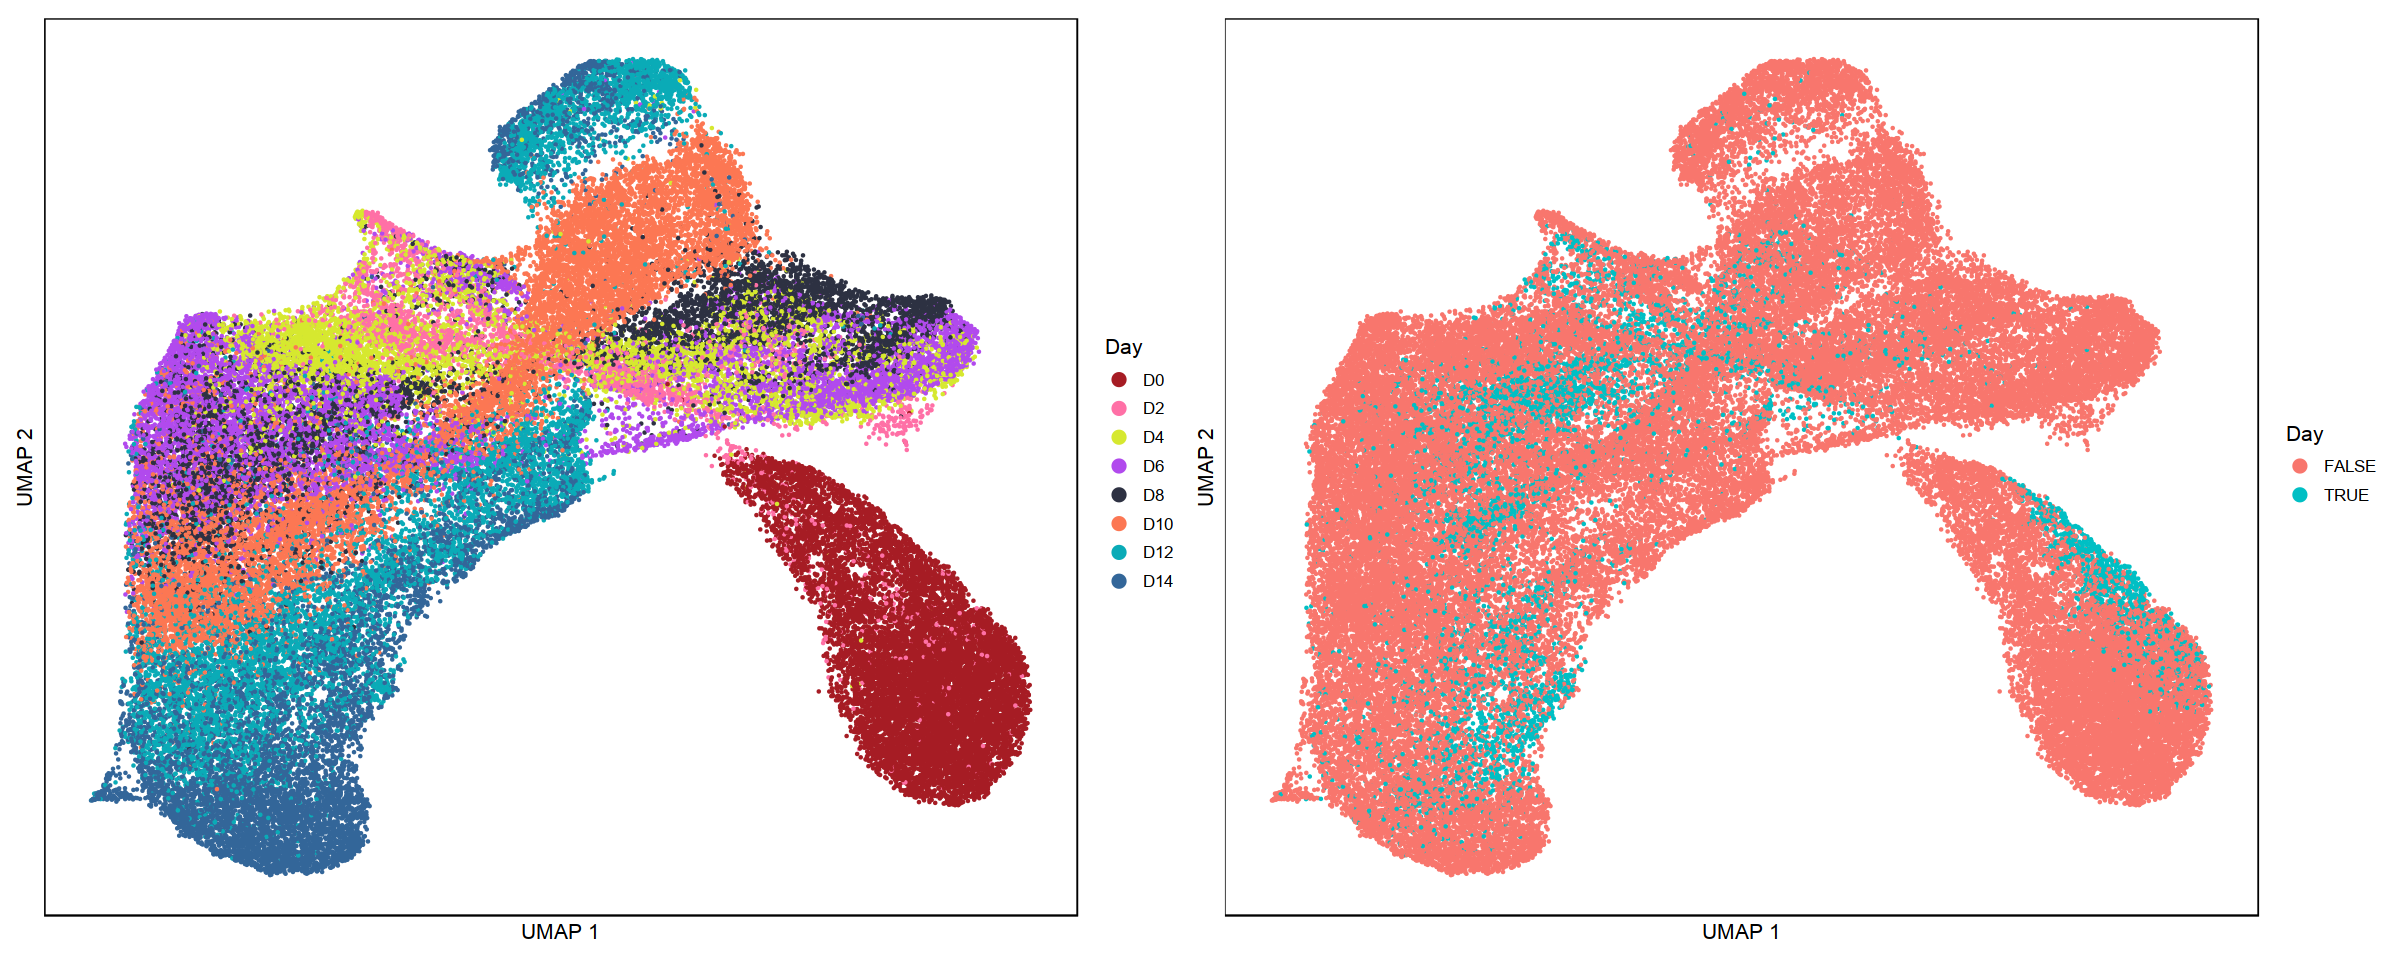

In [321]:
options(repr.plot.width = 20, repr.plot.height = 8)

by_day | by_doub

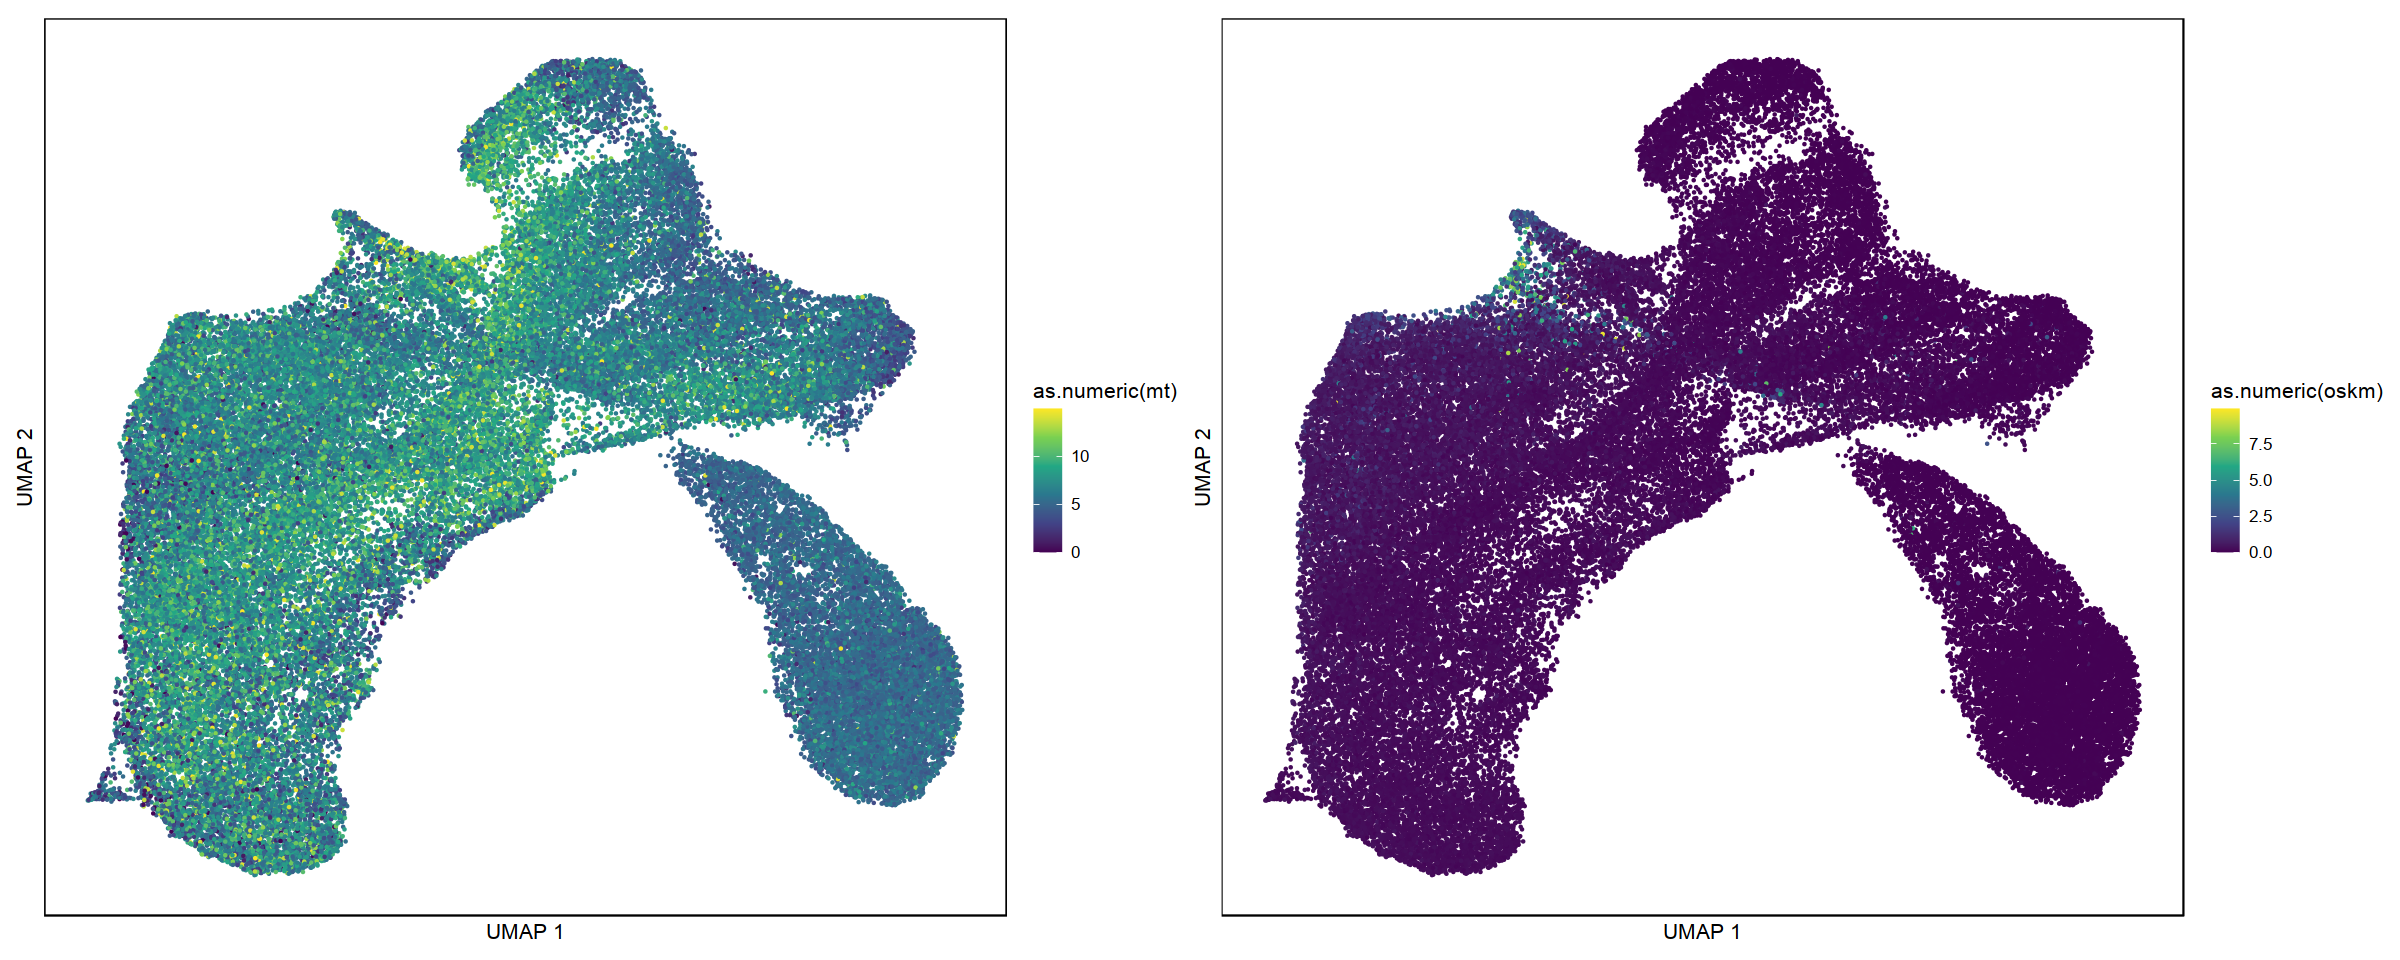

In [278]:
options(repr.plot.width = 20, repr.plot.height = 8)

by_mt | by_oskm

## Without doublets

In [322]:
rna_wo_doub = rna_subset
rna_wo_doub[['doublet']] = rownames(rna_wo_doub@meta.data) %in% doublets

rna_wo_doub = subset(rna_wo_doub, subset = doublet==F)

In [323]:
rna_wo_doub

An object of class Seurat 
27632 features across 59369 samples within 1 assay 
Active assay: RNA (27632 features, 0 variable features)

In [324]:
rna_wo_doub <- NormalizeData(rna_wo_doub)
rna_wo_doub <- FindVariableFeatures(rna_wo_doub, selection.method = "vst", nfeatures = 2000)
all.genes <- rownames(rna_wo_doub)
rna_wo_doub <- ScaleData(rna_wo_doub, features = all.genes)
rna_wo_doub <- RunPCA(rna_wo_doub, features = VariableFeatures(object = rna_sample))
rna_wo_doub <- RunUMAP(rna_wo_doub, dims = 1:10)

Centering and scaling data matrix

PC_ 1 
Positive:  LIM2, PLAAT3, UTF1, MT1G, L1TD1, SPINT2, POU5F1, TUBB4A, ESRG, MT1X 
	   AK4, MT1H, TDGF1, ASRGL1, CD24, SEMA6A, F11R, MIR302CHG, SLIRP, TUBB2B 
	   TTYH1, FRAT2, CD70, NLRP7, LINC00678, EPCAM, LNCPRESS1, KRT18, TNNT1, TNFSF9 
Negative:  LGALS1, COL1A1, TPM2, COL6A3, COL1A2, B2M, COL6A2, SH3BGRL3, FN1, TIMP1 
	   COL6A1, CTSB, CTHRC1, COL3A1, SPARC, MYL9, MMP2, PCOLCE, VIM, CD59 
	   S100A6, MALAT1, HLA-B, IER3, CAV1, LGALS3, TGFBI, TSPO, TAGLN, MARCKS 
PC_ 2 
Positive:  APOE, NLRP7, TDGF1, NLRP2, NODAL, EPCAM, LINC01356, DPPA3, MT1F, FGF4 
	   DNMT3B, FOXD3-AS1, AC064802.1, SAT1, DPPA2, PDLIM1, LIN28A, ESRP1, APOC1, FOXH1 
	   AC005062.1, SLC66A3, MT1H, ERVH48-1, SPINT2, RAB25, PLBD1, PIM1, AC027288.1, UTF1 
Negative:  ANXA1, MYC, CD36, S100A16, GSN, ODC1, SOX2, CAVIN2, PCDH9, ARHGAP18 
	   S100A6, KLF4, PCLAF, PCDH10, PLA2G7, PI16, AZGP1, LINC00437, CALB1, PTHLH 
	   ROBO1, GYPC, THSD7A, NRP2, ALDH1A2, MAP1B, LYPLAL1-DT, SNCG, S100

In [325]:
plot_df <- data.frame(pc1=data.frame(Embeddings(rna_wo_doub, reduction='umap'))$UMAP_1,
                 pc2=data.frame(Embeddings(rna_wo_doub, reduction='umap'))$UMAP_2,
                 sample=rna_wo_doub@meta.data$sample)
plot_df = plot_df[sample(dim(plot_df)[1]), ]

by_day <- ggplot(plot_df) +
geom_point(aes(x=pc1, y=pc2, color=factor(sample, levels=DAYS)), stroke=0, size=1) +
theme_classic() +
scale_color_manual(values=day_config$colour) +
xlab("UMAP 1") + ylab("UMAP 2") +
theme(plot.title = element_text(hjust = 0.5),
      text = element_text(size=12),
      axis.line=element_blank(),
      axis.text.x=element_blank(),
      axis.text.y=element_blank(),
      axis.ticks=element_blank(),
      panel.border = element_rect(colour = "black", fill=NA, size=0.5)) +
guides(colour = guide_legend(title="Day",
     override.aes = list(shape=16, alpha=1, size=4)))

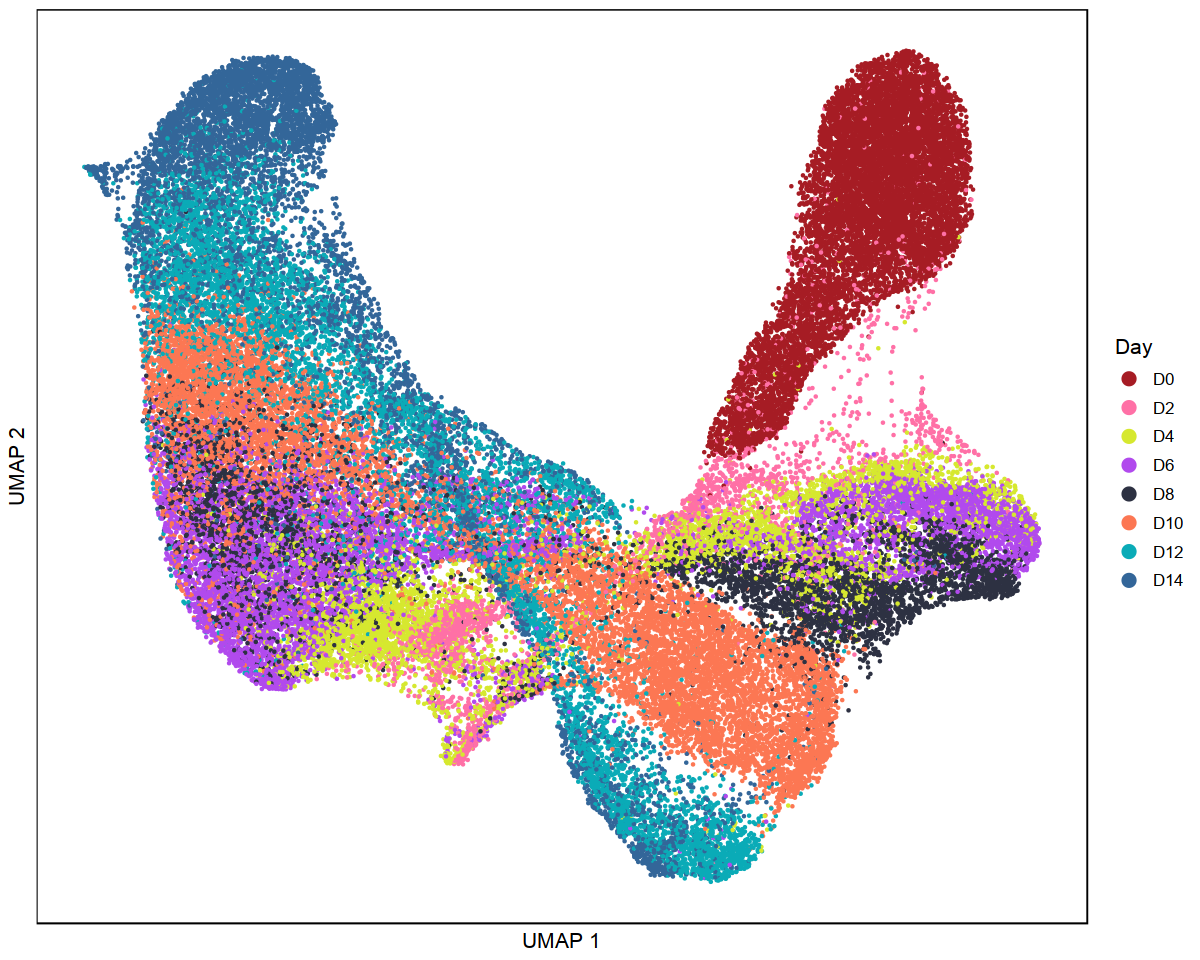

In [326]:
options(repr.plot.width = 10, repr.plot.height = 8)

by_day

In [332]:
write.table(rownames(rna_wo_doub@meta.data),
            file='./barcodes/20200831_nFeat200_mt15_oskm10_nCount2000_pk0.01.txt',
            quote=F,
            row.names=F,
            col.names=F)

[[1]]


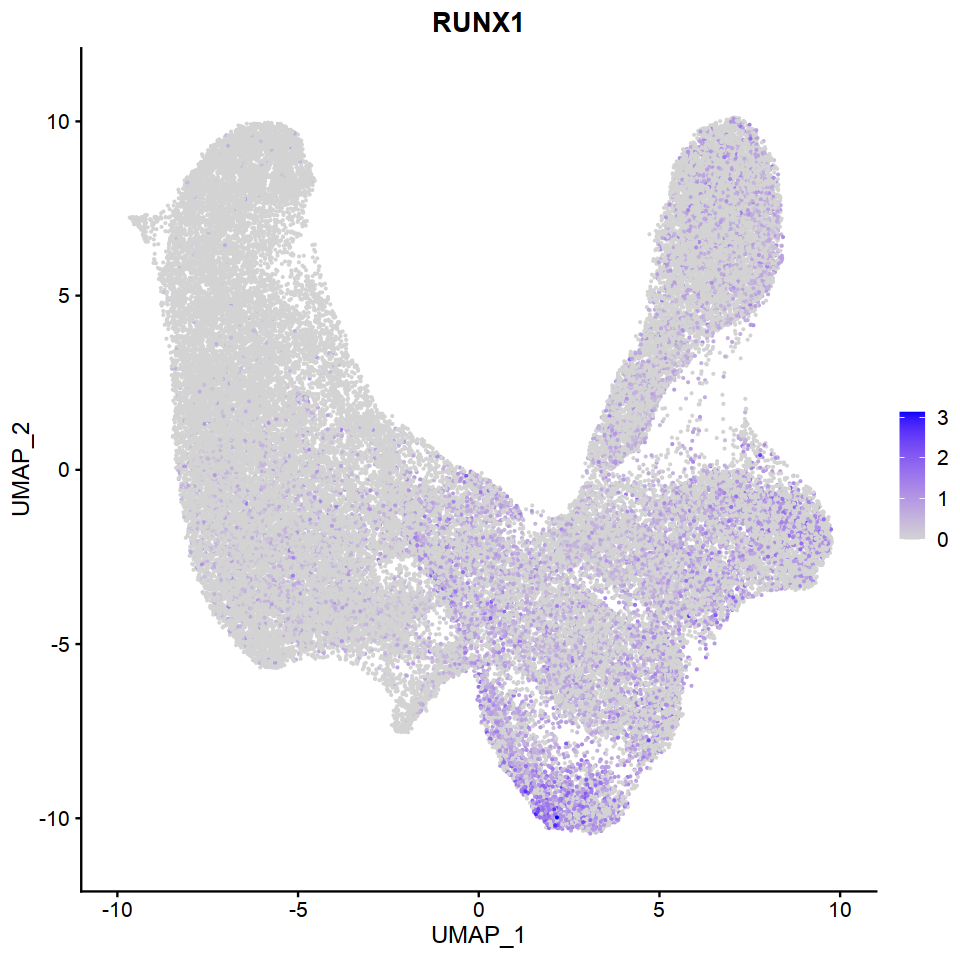

In [331]:
options(repr.plot.width = 8, repr.plot.height = 8)

FeaturePlot(rna_wo_doub, features = c("RUNX1"), reduction = "umap", pt.size = 0.1, combine = FALSE)

---

In [182]:
sessionInfo()

R version 3.6.3 (2020-02-29)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: Ubuntu 18.04.4 LTS

Matrix products: default
BLAS/LAPACK: /users/surag/anaconda3/envs/r36_cran/lib/libopenblasp-r0.3.9.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] grid      stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] ROCR_1.0-11         KernSmooth_2.23-16  fields_10.3        
 [4] maps_3.3.0          spam_2.5-1          dotCall64_1.0-0    
 [7] DoubletFinder_2.0.3 patchwork_1.0.0     ggplot2_3.3.0      
[10] dplyr_0.8.5         Seurat_3.1.5       

loaded via a namespace (and not attached):
 